# ======================= Documentation =======================

Scripts associated with submission to Gretsi 2019

# Information

**Script 1** gives details on all the steps that are preformed to create a signal on a target graph with equivalence in terms of spreads with a given signal on a source graph. Figures are given to illustrate.

**Script 2** studies what we can retrieve when using a single graph.

**Script 3** visualizes the points associated with random signals in the uncertainty region.

**Script 4** uses our method for clustering signals.

# Warning

At this point, in all concerned function calls, *ref_eigenvalue* should be equal to 0 and *ref_vertex* should be fixed. Additional work should be done to extend region border when using more flexible spread definitions.

# ========================== Imports ==========================

In [1]:
import numpy
import matplotlib.lines as lines
import matplotlib.mlab as mlab
import matplotlib.pyplot as pyplot
import pygsp
import scipy.sparse.csgraph as csgraph
import heapq
import scipy.signal
import scipy.stats as stats
import scipy.optimize as optimize
import ot
import sklearn.cluster as skcluster
import sklearn.metrics as skmetrics

# ========================= Functions =========================

# Plotting

Plots a matrix.

**In**
- *matrix*: Matrix to plot.
- *title*: Figure title.
- *file_name*: Where to export if given.

In [2]:
def plot_matrix (matrix, title="", file_name=None) :
    
    # Figure
    pyplot.figure()
    matrix = pyplot.matshow(numpy.real(matrix))
    
    # Additions
    pyplot.title(title)
    pyplot.colorbar(matrix)
    
    # Save and show
    if file_name :
        pyplot.savefig(file_name, dpi=300, bbox_inches="tight")
    pyplot.show()

Plots a graph.

**In**
- *graph*: Graph to plot
- *title*: Figure title.
- *file_name*: Where to export if given.

In [3]:
def plot_graph (graph, title="", file_name=None) :
    
    # Plot of graph
    pyplot.figure()
    pygsp.plotting.plot_graph(graph)
    
    # Additions
    pyplot.title(title)
    
    # Save and show
    if file_name :
        pyplot.savefig(file_name, dpi=300, bbox_inches="tight")
    pyplot.show()

Plots a graph signal.

**In**
- *graph*: Graph on which the signal is defined.
- *signal*: Signal to plot
- *title*: Figure title.
- *file_name*: Where to export if given.

In [4]:
def plot_graph_signal (graph, signal, title="", file_name=None) :
    
    # Plot of signal
    pyplot.figure()
    pygsp.plotting.plot_signal(graph, signal)
    
    # Additions
    pyplot.title(title)
    
    # Save and show
    if file_name :
        pyplot.savefig(file_name, dpi=300, bbox_inches="tight")
    pyplot.show()

Plots a graph signal spectrum.

**In**
- *graph*: Graph on which the signal is defined.
- *signal*: Signal to plot
- *title*: Figure title.
- *file_name*: Where to export if given.

In [5]:
def plot_graph_signal_spectrum (graph, signal, title="", file_name=None) :
    
    # Spectrum
    spectrum = graph.U.transpose().dot(signal)
    
    # Plot of spectrum
    pyplot.figure()
    pyplot.scatter(graph.e, spectrum)
    pyplot.axhline(y=0.0, xmin=0.0, xmax=2.0, color="black", linestyle="--")
    for i in range(spectrum.shape[0]) :
        l = lines.Line2D([graph.e[i], graph.e[i]], [0.0, spectrum[i]])
        pyplot.gca().add_line(l)
    
    # Additions
    pyplot.xlim(0.0, 2.0)
    pyplot.xlabel("Eigenvalues")
    pyplot.ylabel("Energy")
    pyplot.title(title)
    
    # Save and show
    if file_name :
        pyplot.savefig(file_name, dpi=300, bbox_inches="tight")
    pyplot.show()

Plots the uncertainty region associated with a graph.

**In**
- *curves*: List of curves to plot.
- *labels*: Legend labels to associate with the curves.
- *vectors*: List of lines to plot in addition.
- *colors*: If given, colors to give to the curves. Otherwise, they are generated to be distinct.
- *title*: Figure title.
- *file_name*: Where to export if given.

In [6]:
def plot_uncertainty_region (curves, labels=[], vectors=[], show_arrows=False, colors=[], title="", file_name=None) :
    
    # Vectors if asked
    pyplot.figure()
    for vector in vectors :
        if show_arrows :
            pyplot.arrow(*vector, color="0.5", head_width=0.02, head_length=0.4, length_includes_head=True)
        else :
            pyplot.arrow(*vector, color="0.5")

    # One color per label (duplicating last one) or per list of points if nothing asked
    if not colors :
        if len(labels) > 0 :
            colors = pyplot.cm.rainbow(numpy.linspace(0, 1, len(labels)))
        else :
            colors = pyplot.cm.rainbow(numpy.linspace(0, 1, len(curves)))
    if len(colors) < len(curves) :
        colors = numpy.repeat(colors, [1] * (len(labels) - 1) + [len(curves) - len(labels) + 1], axis=0)
    for i in range(len(curves)) :
        if curves[i].ndim == 1 :
            pyplot.scatter(*curves[i].transpose(), c=numpy.array([colors[i]]), label=labels[i] if len(labels) > i else "")
        else :
            pyplot.plot(*curves[i].transpose(), c=colors[i], label=labels[i] if len(labels) > i else "")
    
    # Additions
    pyplot.title(title)
    pyplot.xlabel("Spectral spread")
    pyplot.ylabel("Graph spread")
    if len(labels) > 0 :
        pyplot.legend(loc="upper right")
    
    # Save and show
    if file_name :
        pyplot.savefig(file_name, dpi=300, bbox_inches="tight")
    pyplot.show()

# Utility

Generates a signal which is Gaussian in the spectral domain.

**In**
- *graph*: Graph on which to generate the signal.
- *mu*: Mean of the Gaussian.
- *sigma*: Standard deviation of the Gaussian.

**Out**
- *signal*: Generated signal.

In [7]:
def gaussian_kernel (graph, mu, sigma) :
    
    # Gaussian spectrum
    spectrum = mlab.normpdf(graph.e, mu, sigma)
    spectrum / numpy.linalg.norm(spectrum)
    
    # We return the graph signal
    signal = graph.U.dot(spectrum)
    return signal

Computes the graph spread of a graph with respect to the given vertex. If no vertex is given, it considers the minimizer as the reference one.

**In**
- *graph*: Graph on which to compute the spread.
- *signal*: Signal for which to compute the spread.
- *ref_vertex*: Vertex used for reference.

**Out**
- *graph_spread*: Spread value.
- *optimal_vertex*/*ref_vertex*: Vertex given as an argument if one, otherwise spread minimizer.

In [8]:
def graph_spread (graph, signal, ref_vertex=None) :
    
    # If we already computed the geodesic distances for the graph, we use them
    global all_geodesic_distances
    if "all_geodesic_distances" not in globals() :
        all_geodesic_distances = {}
    if (graph, ref_vertex) not in all_geodesic_distances :
        all_geodesic_distances[(graph, ref_vertex)] = csgraph.shortest_path(graph.W.todense(), indices=ref_vertex)
    geodesic_distances = all_geodesic_distances[(graph, ref_vertex)]

    # Graph spread if ref vertex (Agaskar & Lu)
    if ref_vertex is not None :
        graph_spread = numpy.sum(geodesic_distances**2.0 * signal**2.0)
        return graph_spread, ref_vertex
    
    # Graph spread if no ref vertex (minimizer)
    else :
        graph_spread = float("inf")
        optimal_vertex = None
        for i in range(graph.N) :
            graph_spread_ref = numpy.sum(geodesic_distances[i]**2.0 * signal**2.0)
            if graph_spread_ref < graph_spread :
                graph_spread = graph_spread_ref
                optimal_vertex = i
        return graph_spread, optimal_vertex

Computes the spectral spread of a graph with respect to the given eigenvalue. If no eigenvalue is given, it considers the minimizer as the reference one.

**In**
- *graph*: Graph on which to compute the spread.
- *signal*: Signal for which to compute the spread.
- *ref_eigenvalue*: Eigenvalue used for reference.

**Out**
- *spectral_spread*: Spread value.
- *optimal_eigenvalue*/*ref_eigenvalue*: Eigenvalue given as an argument if one, otherwise spread minimizer.

In [9]:
def spectral_spread (graph, signal, ref_eigenvalue=None) :

    # Signal spectrum
    spectrum = graph.U.transpose().dot(signal)

    # Spectral spread if ref eigenvalue (Agaskar & Lu, they use ref_eigenvalue=0.0)
    if ref_eigenvalue is not None :
        spectral_spread = numpy.sum(numpy.abs(graph.e - ref_eigenvalue) * spectrum**2.0)
        return spectral_spread, ref_eigenvalue
    
    # Spectral spread if no ref eigenvalue (minimizer)
    else :
        spectral_spread = float("inf")
        optimal_eigenvalue = None
        for i in range(graph.N) :
            spectral_spread_ref = numpy.sum(numpy.abs(graph.e - graph.e[i]) * spectrum**2.0)
            if spectral_spread_ref < spectral_spread :
                spectral_spread = spectral_spread_ref
                optimal_eigenvalue = graph.e[i]
        return spectral_spread, optimal_eigenvalue

Returns the spectral and graph spreads of a signal on a graph. Basically just calls *spectral_spread* and *spectral_spread* and drops the optimal eigenvalue/vertex.

**In**
- *graph*: Graph on which to compute the spreads.
- *signal*: Signal for which to compute the spreads.
- *ref_vertex*: Vertex used for reference.
- *ref_eigenvalue*: Eigenvalue used for reference.

**Out**
- *pair*: Uncertainty pair.

In [10]:
def uncertainty_pair (graph, signal, ref_vertex=None, ref_eigenvalue=None) :
    
    # Spreads
    signal_spectral_spread, optimal_eigenvalue = spectral_spread(graph, signal, ref_eigenvalue)
    signal_graph_spread, optimal_vertex = graph_spread(graph, signal, ref_vertex)
    pair = numpy.array([signal_spectral_spread, signal_graph_spread])
    return pair

Applies the sandwich algorithm to approximate the border of the uncertainty region lying between two points. These points must delimit a convex or concave portion of the set border.

**In**
- *source_pair*: Source point (clockwise order), given as an uncertainty pair.
- *target_pair*: Target point (clockwise order), given as an uncertainty pair.
- *graph*: Graph for which we approximate the set border.
- *depth*: Recursion limit for the algorithm to stop.
- *ref_vertex*: Vertex used for reference in graph spread computation.
- *ref_eigenvalue*: Eigenvalue used for reference in spectral spread computation.

**Out**
- *all_pairs*: Points on the uncertainty set border in between the initially given points, given in clockwise order.

In [11]:
# Sandwich algorithm
def sandwich (source_pair, target_pair, graph, depth=7, ref_vertex=None, ref_eigenvalue=None) :
    
    # Useful matrices
    distances = numpy.diag(csgraph.shortest_path(graph.W.todense(), indices=ref_vertex)) ** 2.0
    laplacian = graph.L.todense()
    
    # Recursive function
    def recursive_sandwich (source_pair, target_pair, depth) :
        
        # Stop condition
        if depth == 0 :
            return [target_pair]

        # Sandwich computation of a point
        alpha = (source_pair[1] - target_pair[1]) / (source_pair[0] - target_pair[0])
        matrix = distances - alpha * laplacian
        matrix_eigenvalues, matrix_eigenvectors = numpy.linalg.eig(matrix)
        if target_pair[0] > source_pair[0] :
            idx = matrix_eigenvalues.argsort()[::-1]
        else :
            idx = matrix_eigenvalues.argsort()[::1]
        matrix_eigenvalues = matrix_eigenvalues[idx]
        matrix_eigenvectors = matrix_eigenvectors[:, idx]
        signal = numpy.array(matrix_eigenvectors[:, 0].transpose().tolist()[0])
        pair = uncertainty_pair(graph, signal, ref_vertex=ref_vertex, ref_eigenvalue=ref_eigenvalue)
        return numpy.concatenate((recursive_sandwich(source_pair, pair, depth - 1), recursive_sandwich(pair, target_pair, depth - 1)))

    # Initial call
    all_pairs = numpy.concatenate(([source_pair], recursive_sandwich(source_pair, target_pair, depth)))
    return all_pairs

Applies the sandwich algorithm on all identifiable portions of the uncertainty region in order to approximate the whole set.

**Warning: At this point, *ref_eigenvalue* should be equal to 0 and *ref_vertex* should be fixed. Additional work should be done to extend region border when using more flexible spread definitions.**

**In**
- *graph*: Graph for which we approximate the set border.
- *ref_vertex*: Vertex used for reference in graph spread computation.
- *ref_eigenvalue*: Eigenvalue used for reference in spectral spread computation.
- *depth*: Recursion depth for the sandwich algorithm.

**Out**
- *region_border*: All points that were sampled on the set border, with first being (1, 0) and subsequent in clockwise order.
- *region_border_for_plot*: Same as *region_border*, but divided in 4 curves for plotting the results.

In [12]:
def approximate_uncertainty_region (graph, ref_vertex=None, ref_eigenvalue=None, depth=7) :
    
    # Well-identified points (clockwise starting with bottom)
    distances = csgraph.shortest_path(graph.W.todense(), indices=ref_vertex) ** 2.0
    farthest_dirac = (distances == distances.max()).astype(float)
    identified_pairs = numpy.array([[1, 0], \
                                    uncertainty_pair(graph, graph.U[:, 0], ref_vertex=ref_vertex, ref_eigenvalue=ref_eigenvalue), \
                                    uncertainty_pair(graph, farthest_dirac, ref_vertex=ref_vertex, ref_eigenvalue=ref_eigenvalue), \
                                    uncertainty_pair(graph, graph.U[:, -1], ref_vertex=ref_vertex, ref_eigenvalue=ref_eigenvalue)])

    # Sandwich algorithm for all parts of graph
    region_border = numpy.array([]).reshape(0, 2)
    region_border_for_plot = []
    for i in range(identified_pairs.shape[0]) :

        # Sandwich on the portion
        source_pair = identified_pairs[i]
        target_pair = identified_pairs[(i + 1) % identified_pairs.shape[0]]
        portion_pairs = sandwich(source_pair, target_pair, graph, depth, ref_vertex=ref_vertex, ref_eigenvalue=ref_eigenvalue)

        # Save
        region_border = numpy.concatenate((region_border, portion_pairs[:-1]))
        region_border_for_plot.append(portion_pairs)

    # We return useful stuff
    return region_border, region_border_for_plot

Computes the barycenter of a set of points.

**In**
- points: Points for which to compute the barycenter.

**Out**
- barycenter: Point at the barycenter of the given points.

In [13]:
def compute_barycenter (points) :
    
    # Uniform contribution
    barycenter = points.sum(axis=0) / points.shape[0]
    return barycenter

Finds the point at the intersection of two lines.

**In**
- *line_1*: First line, given as two uncertainty pairs.
- *line_2*: Second line, given as two uncertainty pairs.

**Out**
- *point*: Point at the intersection of the lines.

In [14]:
def line_intersection (line_1, line_2) :

    # Deltas
    x_diff = (line_1[0][0] - line_1[1][0], line_2[0][0] - line_2[1][0])
    y_diff = (line_1[0][1] - line_1[1][1], line_2[0][1] - line_2[1][1])
    
    # Determinant
    def det (a, b) :
        return a[0] * b[1] - a[1] * b[0]
    
    # Check if parallel
    div = det(x_diff, y_diff)
    if div == 0 :
       raise Exception("Lines do not intersect")
    
    # Point
    d = (det(*line_1), det(*line_2))
    point = numpy.array([det(d, x_diff), det(d, y_diff)]) / div
    return point

Returns the pair in the target region that corresponds to a pair in the source region.

**In**
- *source_region_border*: Pairs delimiting the uncertainty region of the source graph.
- *target_region_border*: Points delimiting the uncertainty region of the target graph.
- *source_pair*: Pair of the source region for which to find an equivalent in the target region.

**Out**
- *target_pair*: Uncertainty pair corresponding to the pair to find in the source region.
- *best_i*: Index of the triangle in which source pair is found.

In [15]:
def find_equivalent_pair (source_region_border, target_region_border, source_pair) :

    # We will need the barycenters
    source_region_barycenter = compute_barycenter(source_region_border)
    target_region_barycenter = compute_barycenter(target_region_border)
    region_border_size = source_region_border.shape[0]
    
    # First, we find which triangle (source_barycenter, source_point_i, source_point_i+1) contains the signal
    source_best_angles_diff = float("inf")
    best_i = None
    for i in range(region_border_size) :

        # Points of interest (with respect to the barycenter of the source region)
        source_point_pair = source_pair - source_region_barycenter
        source_point_i = source_region_border[i] - source_region_barycenter
        source_point_ip1 = source_region_border[(i + 1) % region_border_size] - source_region_barycenter

        # Norms of the segments between these points and the barycenter (which has been moved previously to (0, 0))
        source_norm_pair = numpy.linalg.norm(source_point_pair)
        source_norm_i = numpy.linalg.norm(source_point_i)
        source_norm_ip1 = numpy.linalg.norm(source_point_ip1)
        source_norm_i_ip1 = numpy.linalg.norm(source_point_i - source_point_ip1)
        source_norm_i_pair = numpy.linalg.norm(source_point_i - source_point_pair)
        source_norm_ip1_pair = numpy.linalg.norm(source_point_ip1 - source_point_pair)

        # Angles with the barycenter for all 3 possible triangles
        source_angle_i_ip1 = numpy.arccos((source_norm_i**2.0 + source_norm_ip1**2.0 - source_norm_i_ip1**2.0) / (2.0 * source_norm_i * source_norm_ip1))
        source_angle_i_pair = numpy.arccos((source_norm_i**2.0 + source_norm_pair**2.0 - source_norm_i_pair**2.0) / (2.0 * source_norm_i * source_norm_pair))
        source_angle_ip1_pair = numpy.arccos((source_norm_ip1**2.0 + source_norm_pair**2.0 - source_norm_ip1_pair**2.0) / (2.0 * source_norm_ip1 * source_norm_pair))

        # We find the point intersecting (i, ip1) along the line (barycenter, pair)
        source_line_barycenter_signal = numpy.concatenate((numpy.zeros((1, 2)), [source_point_pair]))
        source_line_i_ip1 = numpy.concatenate(([source_point_i], [source_point_ip1]))
        source_point_between_i_ip1 = line_intersection(source_line_barycenter_signal, source_line_i_ip1)
        source_norm_between_i_ip1 = numpy.linalg.norm(source_point_between_i_ip1)

        # Point is in the triangle if angles sum correctly
        source_angles_diff = abs(source_angle_i_pair + source_angle_ip1_pair - source_angle_i_ip1)
        if source_angles_diff < source_best_angles_diff :
            angle_i_ratio = source_angle_i_pair / source_angle_i_ip1
            norm_i_ratio = source_norm_pair / source_norm_between_i_ip1
            source_best_angles_diff = source_angles_diff
            best_i = i

    # Points of interest (with respect to the barycenter of the target graph)
    target_point_i = target_region_border[best_i] - target_region_barycenter
    target_point_ip1 = target_region_border[(best_i + 1) % region_border_size] - target_region_barycenter

    # Norms of the segments between these points and the barycenter (which has been moved previously to (0, 0))
    target_norm_point_i = numpy.linalg.norm(target_point_i)
    target_norm_point_ip1 = numpy.linalg.norm(target_point_ip1)
    target_norm_i_ip1 = numpy.linalg.norm(target_point_i - target_point_ip1)

    # We retranscript the point found in source region to the target region
    target_angle_i_pair = angle_i_ratio * numpy.arccos((target_norm_point_i**2.0 + target_norm_point_ip1**2.0 - target_norm_i_ip1**2.0) / (2.0 * target_norm_point_i * target_norm_point_ip1))
    rotation = numpy.array([[numpy.cos(target_angle_i_pair), numpy.sin(target_angle_i_pair)], \
                            [-numpy.sin(target_angle_i_pair), numpy.cos(target_angle_i_pair)]])
    target_rotated_unit_vector = rotation.dot(target_point_i.transpose()).transpose() / target_norm_point_i
    target_line_barycenter_rotated = numpy.concatenate((numpy.zeros((1, 2)), [target_rotated_unit_vector]))
    target_line_i_ip1 = numpy.concatenate(([target_point_i], [target_point_ip1]))
    target_point_i_ip1 = line_intersection(target_line_barycenter_rotated, target_line_i_ip1)
    target_norm_point_i_ip1 = numpy.linalg.norm(target_point_i_ip1)
    target_pair = target_region_barycenter + norm_i_ratio * target_norm_point_i_ip1 * target_rotated_unit_vector

    # We return the uncertainty pair and triangle index
    return target_pair, best_i

Perturbates a random signal until a target uncertainty pair is achieved.

**In**
- *source_graph*: Initial graph in which *source_signal* is defined.
- *source_signal*: Signal on *source_graph* for which we give an equivalent uncertainty pair in target region to achieve.
- *target_graph*: Graph on which we want to find a signal realizing the *target_pair*.
- *target_region_border*: Points delimiting the uncertainty region of the target graph.
- *target_pair*: Uncertainty pair in target region that we want to reach witha signal on target graph.
- *evaluate_solution*: Function to give a score (smaller=better) to a temporary solution based on additional priors.
- *ref_vertex*: Vertex used for reference in graph spread computation.
- *ref_eigenvalue*: Eigenvalue used for reference in spectral spread computation.
- *max_iterations*: Maximum number of iterations before stopping.
- *perturbation_value*: Initial perturbation value for the signal entries.
- *perturbation_update_factor*: Factor by which we reduce the perturbation size if no perturbation improved the result.
- *close_enough*: Distance to the solution under which we consider convergence is achieved.
- *update_domain*: If "graph", we perturbate temporary solutions in the graph domain, otherwise in the spectral domain.
- *verbose*: Plots progression if True.

**Out**
- *target_signal*: Signal achieving the target uncertainty pair.

In [16]:
def find_signal_with_uncertainty (source_graph, source_signal, target_graph, target_region_border, target_pair, evaluate_solution=None, ref_vertex=None, ref_eigenvalue=None, max_iterations=1000, perturbation_value=1.0, perturbation_update_factor=10.0, close_enough=1e-9, update_domain="graph", verbose=False) :

    # If no heuristic is provided, we use the solution that fastens convergence
    if not evaluate_solution :
        def heuristic_fastest (source_graph, source_signal, target_signal_pair, target_graph, current_target_signal, current_target_pair) :
            return numpy.linalg.norm(target_signal_pair - current_target_pair)
        evaluate_solution = heuristic_fastest
    
    # Initialization with a random signal on the target graph
    if update_domain == "graph" :
        target_signal = numpy.random.rand(target_graph.N)
        target_signal /= numpy.linalg.norm(target_signal)
    else :
        target_spectrum = numpy.random.rand(target_graph.N)
        target_spectrum /= numpy.linalg.norm(target_spectrum)
        target_signal = target_graph.U.dot(target_spectrum)
    target_signal_pair = uncertainty_pair(target_graph, target_signal, ref_vertex=ref_vertex, ref_eigenvalue=ref_eigenvalue)
    target_signal_score = evaluate_solution(source_graph, source_signal, target_pair, target_graph, target_signal, target_signal_pair)
    distance_to_objective = numpy.linalg.norm(target_pair - target_signal_pair)
    
    # Variable for verbose run
    if verbose :
        all_steps = numpy.array([]).reshape(0, 2)
        target_region_barycenter = compute_barycenter(target_region_border)
        target_region_border_for_plot = numpy.concatenate((target_region_border, [target_region_border[0]]))
    
    # Now we try to find the signal leading to the pair identified in the target region
    for it in range(max_iterations) :

        # Plot of progression
        if verbose :
            all_steps = numpy.concatenate((all_steps, [target_signal_pair]))
            if it % 10 == 0 or distance_to_objective <= close_enough :
                print("Iteration " + str(it + 1) + "/" + str(max_iterations))
                print("Distance to objective:", distance_to_objective)
                print("Score of the solution:", target_signal_score)
                print("Perturbation value:", perturbation_value)
                plot_uncertainty_region([target_region_border_for_plot, target_region_barycenter, target_pair, all_steps, target_signal_pair], \
                                        ["Target region", "Barycenter of target region", "Proxy pair", "Previous pairs", "Current pair"], \
                                        colors=["green", "green", "cyan", "blue", "blue"], \
                                        title="Convergence toward the objective uncertainty pair")
        
        # We stop if close enough to the target
        if distance_to_objective <= close_enough :
            if verbose :
                print("Converged before max number of iterations")
            break
        
        # We also stop if we are stuck
        if perturbation_value <= close_enough :
            if verbose :
                print("Stuck in a local minimum")
            break

        # We update the signal a bit
        found_good_update = False
        while not found_good_update :
            
            # We store all perturbed signals with their scores
            perturbed_target_signals_tmp = []
            for i in range(target_graph.N) :
                for perturbation_sign in [-1, 1] :

                    # Perturbation of the current state
                    if update_domain == "graph" :
                        target_signal_tmp = target_signal.copy()
                        target_signal_tmp[i] += perturbation_sign * perturbation_value
                        target_signal_tmp /= numpy.linalg.norm(target_signal_tmp)
                    else :
                        target_spectrum_tmp = target_graph.U.transpose().dot(target_signal)
                        target_spectrum_tmp[i] += perturbation_sign * perturbation_value
                        target_spectrum_tmp /= numpy.linalg.norm(target_spectrum_tmp)
                        target_signal_tmp = target_graph.U.dot(target_spectrum_tmp)
                    target_signal_pair_tmp = uncertainty_pair(target_graph, target_signal_tmp, ref_vertex=ref_vertex, ref_eigenvalue=ref_eigenvalue)
                    
                    # We give a score to the solution
                    target_signal_score_tmp = evaluate_solution(source_graph, source_signal, target_pair, target_graph, target_signal_tmp, target_signal_pair_tmp)
                    heapq.heappush(perturbed_target_signals_tmp, (target_signal_score_tmp, numpy.random.rand(), target_signal_tmp, target_signal_pair_tmp))

            # We check solutions in descending score order until we find one that improves distance to objective
            while perturbed_target_signals_tmp :
                
                # Current distance to objective
                target_signal_score_tmp, random_tiebreaker, target_signal_tmp, target_signal_pair_tmp = heapq.heappop(perturbed_target_signals_tmp)
                distance_to_objective_tmp = numpy.linalg.norm(target_pair - target_signal_pair_tmp)
                
                # If better, we choose this solution as the next step
                if distance_to_objective_tmp < distance_to_objective :
                    found_good_update = True
                    target_signal = target_signal_tmp
                    target_signal_pair = target_signal_pair_tmp
                    target_signal_score = target_signal_score_tmp
                    distance_to_objective = distance_to_objective_tmp
                    break
            
            # If no good solution was found, we update the convergence rate
            if not found_good_update :
                perturbation_value /= perturbation_update_factor

    # We return the signal achieving the given uncertainty pair
    return target_signal

Chebyshev filtering of a signal. Code by Clement Vignac @ EPFL.

**In**
- *L*: Laplacian matrix.
- *x*: Signal(s) to filter.
- *k*: Polynomial order.

**Out**
- *last*: Matrix of filtered signal(s).

In [17]:
def chebyshev_filter (L, x, k):
    _k = k + 1      # include polynomials of power k
    old = x
    if k == 0:
        return old
    new = L @ x
    if k == 1:
        return new
    for i in range(2, _k):
        temp = 2 * L @ new - old
        old = new
        new = temp
    last = new
    return last

# ========================== Script 1 ==========================

In [18]:
# Constants
N_SOURCE = 100
N_TARGET = 150
REF_VERTEX_SOURCE = 0
REF_VERTEX_TARGET = 0
REF_EIGENVALUE = 0.0
CHEBYSHEV_ORDER = 5
RANDOM_SEED = 42

<Figure size 432x288 with 0 Axes>

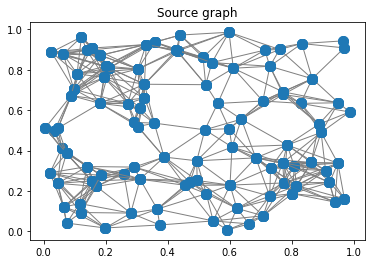

<Figure size 432x288 with 0 Axes>

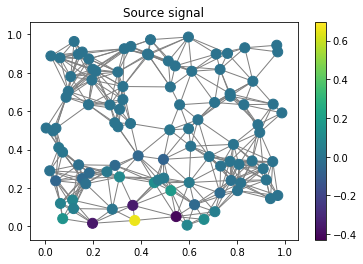

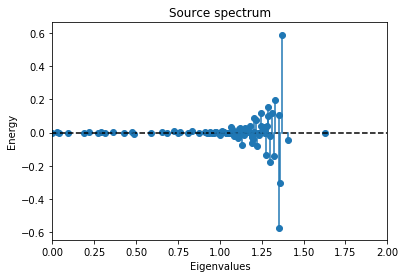

<Figure size 432x288 with 0 Axes>

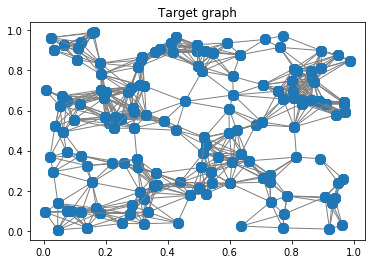

<Figure size 432x288 with 0 Axes>

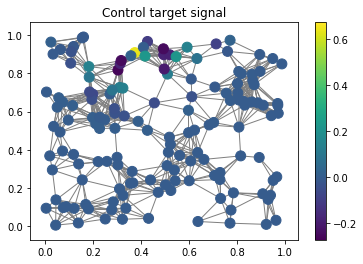

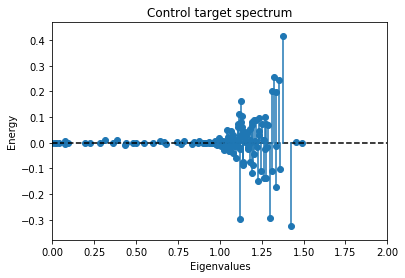

In [20]:
# Random seed
numpy.random.seed(RANDOM_SEED)

# Source graph
source_graph = pygsp.graphs.Sensor(N_SOURCE, seed=RANDOM_SEED)
source_graph.compute_laplacian("normalized")
source_graph.compute_fourier_basis()

# Target graph
target_graph = pygsp.graphs.Sensor(N_TARGET, seed=RANDOM_SEED)
target_graph.compute_laplacian("normalized")
target_graph.compute_fourier_basis()

# Signal on the source graph
source_signal = chebyshev_filter(source_graph.L, scipy.signal.unit_impulse(source_graph.N, REF_VERTEX_SOURCE), CHEBYSHEV_ORDER)
source_signal /= numpy.linalg.norm(source_signal)
source_spectrum = source_graph.U.transpose().dot(source_signal)
source_signal_pair = uncertainty_pair(source_graph, source_signal, ref_vertex=REF_VERTEX_SOURCE, ref_eigenvalue=REF_EIGENVALUE)

# Equivalent signal on the target graph
control_target_signal = chebyshev_filter(target_graph.L, scipy.signal.unit_impulse(target_graph.N, REF_VERTEX_TARGET), CHEBYSHEV_ORDER)
control_target_signal /= numpy.linalg.norm(control_target_signal)
control_target_spectrum = target_graph.U.transpose().dot(control_target_signal)
control_target_signal_pair = uncertainty_pair(target_graph, control_target_signal, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE)

######################################################################################################################

# Graphs
plot_graph(source_graph, title="Source graph", file_name="output/Gretsi2019/source_graph.png")
plot_graph_signal(source_graph, source_signal, title="Source signal", file_name="output/Gretsi2019/source_signal.png")
plot_graph_signal_spectrum(source_graph, source_signal, title="Source spectrum", file_name="output/Gretsi2019/source_spectrum.png")
plot_graph(target_graph, title="Target graph", file_name="output/Gretsi2019/target_graph.png")
plot_graph_signal(target_graph, control_target_signal, title="Control target signal", file_name="output/Gretsi2019/control_target_signal.png")
plot_graph_signal_spectrum(target_graph, control_target_signal, title="Control target spectrum", file_name="output/Gretsi2019/control_target_spectrum.png")

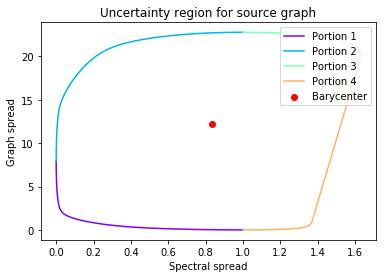

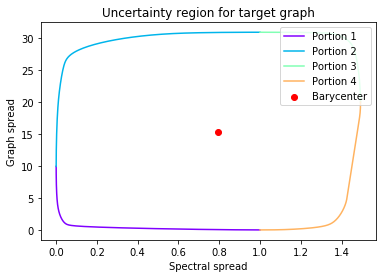

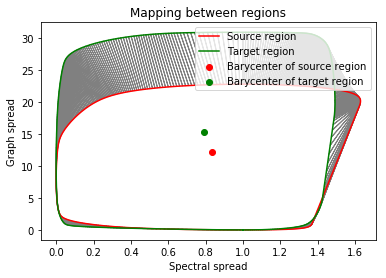

In [23]:
# Uncertainty regions
source_region_border, source_region_border_for_plot = approximate_uncertainty_region(source_graph, ref_vertex=REF_VERTEX_SOURCE, ref_eigenvalue=REF_EIGENVALUE)
target_region_border, target_region_border_for_plot = approximate_uncertainty_region(target_graph, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE)

# Barycenter
region_border_size = source_region_border.shape[0]
source_region_barycenter = compute_barycenter(source_region_border)
target_region_barycenter = compute_barycenter(target_region_border)

######################################################################################################################

# Uncertainty regions
plot_uncertainty_region(source_region_border_for_plot + [source_region_barycenter], \
                        ["Portion 1", "Portion 2", "Portion 3", "Portion 4", "Barycenter"], \
                        title="Uncertainty region for source graph", \
                        file_name="output/Gretsi2019/source_region.png")
plot_uncertainty_region(target_region_border_for_plot + [target_region_barycenter], \
                        ["Portion 1", "Portion 2", "Portion 3", "Portion 4", "Barycenter"], \
                        title="Uncertainty region for target graph", \
                        file_name="output/Gretsi2019/target_region.png")

# For subsequent plots, we won't distinguish portions
source_region_border_for_plot = numpy.concatenate((source_region_border, [source_region_border[0]]))
target_region_border_for_plot = numpy.concatenate((target_region_border, [target_region_border[0]]))

# Mapping between regions
border_vectors = numpy.concatenate((source_region_border, target_region_border - source_region_border), axis=1)
plot_uncertainty_region([source_region_border_for_plot, target_region_border_for_plot, source_region_barycenter, target_region_barycenter], \
                        ["Source region", "Target region", "Barycenter of source region", "Barycenter of target region"], \
                        vectors=border_vectors, \
                        colors=["red", "green", "red", "green"], \
                        title="Mapping between regions", \
                        file_name="output/Gretsi2019/mapping.png")

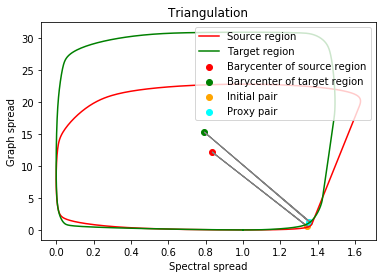

In [24]:
# We find the equivalent point of the considered signal in the target region
target_signal_pair, triangle_index = find_equivalent_pair(source_region_border, target_region_border, source_signal_pair)

######################################################################################################################

# Result with associated triangulation
source_point_i = source_region_border[triangle_index]
source_point_ip1 = source_region_border[(triangle_index + 1) % region_border_size]
target_point_i = target_region_border[triangle_index]
target_point_ip1 = target_region_border[(triangle_index + 1) % region_border_size]
line_1 = numpy.concatenate(([source_region_barycenter], [source_point_i - source_region_barycenter]), axis=1)
line_2 = numpy.concatenate(([source_region_barycenter], [source_point_ip1 - source_region_barycenter]), axis=1)
line_3 = numpy.concatenate(([target_region_barycenter], [target_point_i - target_region_barycenter]), axis=1)
line_4 = numpy.concatenate(([target_region_barycenter], [target_point_ip1 - target_region_barycenter]), axis=1)
all_vectors = numpy.concatenate((line_1, line_2, line_3, line_4))
plot_uncertainty_region([source_region_border_for_plot, target_region_border_for_plot, source_region_barycenter, target_region_barycenter, source_signal_pair, target_signal_pair], \
                        ["Source region ", "Target region", "Barycenter of source region", "Barycenter of target region", "Initial pair", "Proxy pair"], \
                        vectors=all_vectors, \
                        colors=["red", "green", "red", "green", "orange", "cyan"], \
                        title="Triangulation", \
                        file_name="output/Gretsi2019/triangulation.png")

In [25]:
# This uses a homemade search strategy.
# Not as good as using a more intelligent optimizer
ignore_block = True
if not ignore_block :

    # Heuristic to privilegiate solution with similar moments
    def heuristic (source_graph, source_signal, target_signal_pair, target_graph, current_target_signal, current_target_pair) :

        # No heuristic: converge as fast as possible
        #return numpy.linalg.norm(current_target_pair - target_signal_pair)

        # Parameters
        nb_moments = 10

        # Difference in moments between signals
        signal_moments_diffs = []
        for i in range(nb_moments) :
            signal_moments_diffs.append(numpy.abs(stats.moment(source_signal, moment=i) - stats.moment(current_target_signal, moment=i)))

        # Difference in moments between spectrums
        current_spectrum = target_graph.U.transpose().dot(current_target_signal)
        spectrum_moments_diffs = []
        for i in range(nb_moments) :
            spectrum_moments_diffs.append(numpy.abs(stats.moment(source_spectrum, moment=i) - stats.moment(current_spectrum, moment=i)))

        # Done
        return sum(signal_moments_diffs) + sum(spectrum_moments_diffs)

    # We minimize that function to find a signal achieving the target
    target_signal = find_signal_with_uncertainty(source_graph, source_signal, target_graph, target_region_border, target_signal_pair, evaluate_solution=heuristic, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE, verbose=True)
    retrieved_signal_pair = uncertainty_pair(target_graph, target_signal, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE)

    ######################################################################################################################

    # Result signal
    plot_graph_signal(source_graph, source_signal, title="Source signal")
    plot_graph_signal_spectrum(source_graph, source_signal, title="Source spectrum")
    plot_graph_signal(target_graph, target_signal, title="Target signal", file_name="output/Gretsi2019/target_signal.png")
    plot_graph_signal_spectrum(target_graph, target_signal, title="Target spectrum", file_name="output/Gretsi2019/target_spectrum.png")
    plot_graph_signal(target_graph, expected_target_signal, title="Expected (?) target signal")
    plot_graph_signal_spectrum(target_graph, expected_target_signal, title="Expected (?) target spectrum")
    plot_uncertainty_region([target_region_border, target_region_barycenter, target_signal_pair, retrieved_signal_pair], \
                            ["Target region", "Barycenter of target region", "Proxy pair", "Pair of found solution"], \
                            colors=["green", "green", "orange", "cyan"], \
                            title="Uncertainty region", \
                            file_name="output/Gretsi2019/final_result.png")


<Figure size 432x288 with 0 Axes>

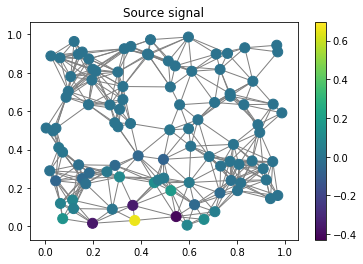

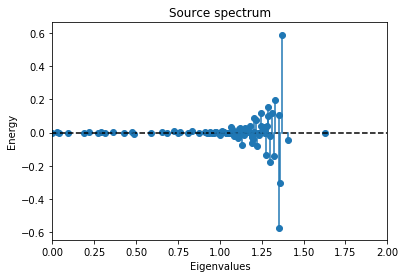

<Figure size 432x288 with 0 Axes>

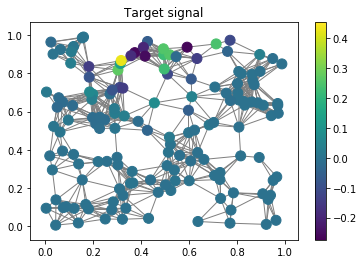

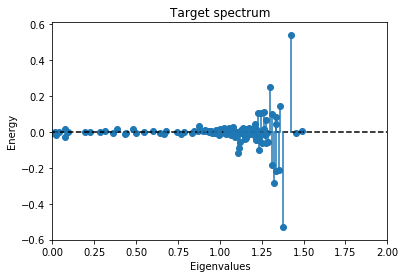

<Figure size 432x288 with 0 Axes>

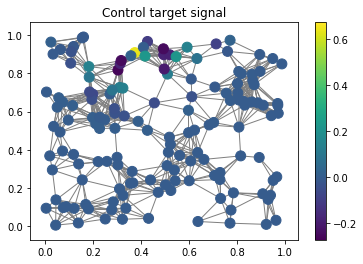

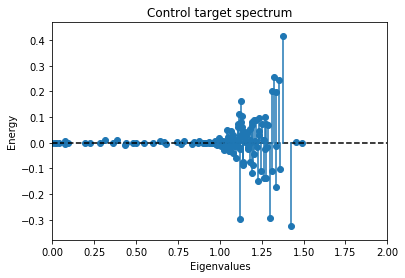

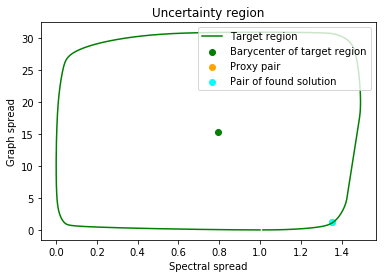

In [27]:
# We do the same with more intelligent optimization methods
# Heuristic to privilegiate solution with similar moments
def function_to_optimize (current_signal) :
    
    # Parameters
    nb_moments = 10

    # Difference in moments between signals
    signal_moments_diffs = []
    for i in range(nb_moments) :
        signal_moments_diffs.append(numpy.abs(stats.moment(source_signal, moment=i) - stats.moment(current_signal, moment=i)))

    # Difference in moments between spectrums
    current_spectrum = target_graph.U.transpose().dot(current_signal)
    spectrum_moments_diffs = []
    for i in range(nb_moments) :
        spectrum_moments_diffs.append(numpy.abs(stats.moment(source_spectrum, moment=i) - stats.moment(current_spectrum, moment=i)))

    # Done
    return sum(signal_moments_diffs) + sum(spectrum_moments_diffs)

# Optimization
initial_signal = numpy.random.rand(target_graph.N)
initial_signal /= numpy.linalg.norm(initial_signal)
optimization_result = optimize.minimize(function_to_optimize, \
                                        initial_signal, \
                                        constraints=[{"type": "eq", "fun": lambda x: numpy.linalg.norm(target_signal_pair - uncertainty_pair(target_graph, x, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE))}, \
                                                     {"type": "eq", "fun": lambda x: numpy.linalg.norm(x) - 1}], \
                                        options={"disp": True, \
                                                 "maxiter": 1000}, \
                                        method="SLSQP")
target_signal = optimization_result.x
retrieved_signal_pair = uncertainty_pair(target_graph, target_signal, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE)

######################################################################################################################

# Result signal
plot_graph_signal(source_graph, source_signal, title="Source signal")
plot_graph_signal_spectrum(source_graph, source_signal, title="Source spectrum")
plot_graph_signal(target_graph, target_signal, title="Target signal", file_name="output/Gretsi2019/target_signal_opt.png")
plot_graph_signal_spectrum(target_graph, target_signal, title="Target spectrum", file_name="output/Gretsi2019/target_spectrum_opt.png")
plot_graph_signal(target_graph, control_target_signal, title="Control target signal")
plot_graph_signal_spectrum(target_graph, control_target_signal, title="Control target spectrum")
plot_uncertainty_region([target_region_border, target_region_barycenter, target_signal_pair, retrieved_signal_pair], \
                        ["Target region", "Barycenter of target region", "Proxy pair", "Pair of found solution"], \
                        colors=["green", "green", "orange", "cyan"], \
                        title="Uncertainty region", \
                        file_name="output/Gretsi2019/final_result_opt.png")

# ========================== Script 2 ==========================

In [23]:
# Constants
N = 50
REF_VERTEX_SOURCE = 0
REF_VERTEX_TARGET = 0
REF_EIGENVALUE = 0.0
CHEBYSHEV_ORDER = 5
RANDOM_SEED = 42

<Figure size 432x288 with 0 Axes>

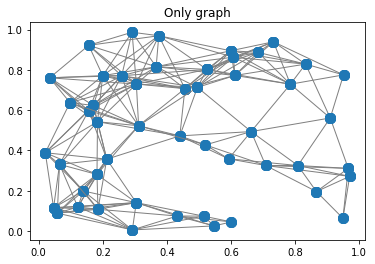

In [24]:
# Random seed
numpy.random.seed(RANDOM_SEED)

# Source graph
source_graph = pygsp.graphs.Sensor(N, seed=RANDOM_SEED)
source_graph.compute_laplacian("normalized")
source_graph.compute_fourier_basis()

# Target graph, here the same as the source graph
target_graph = source_graph
target_graph.compute_laplacian("normalized")
target_graph.compute_fourier_basis()

######################################################################################################################

# Graphs
plot_graph(source_graph, title="Only graph")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  after removing the cwd from sys.path.


Random spectrum
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.220504772842195e-05
            Iterations: 113
            Function evaluations: 5956
            Gradient evaluations: 113


<Figure size 432x288 with 0 Axes>

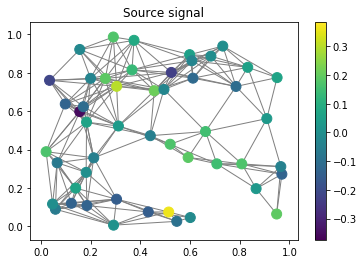

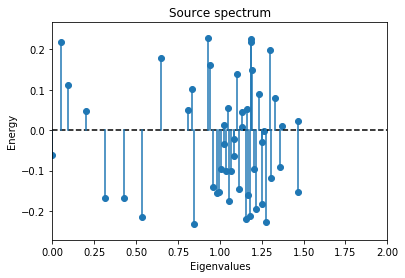

<Figure size 432x288 with 0 Axes>

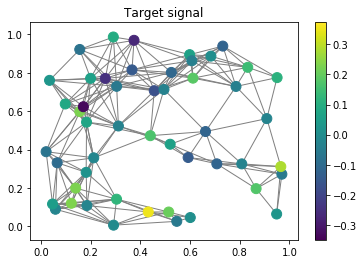

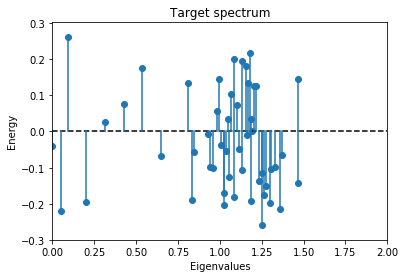

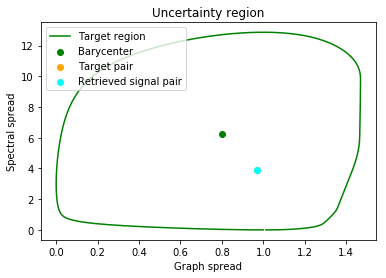

First eigenvector
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.14208179522523376
            Iterations: 1001
            Function evaluations: 57610
            Gradient evaluations: 1001


<Figure size 432x288 with 0 Axes>

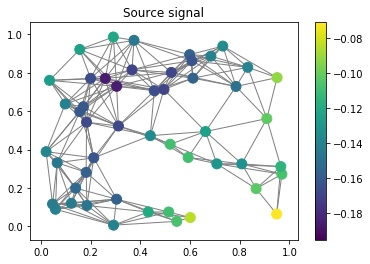

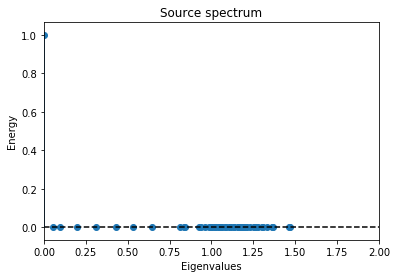

<Figure size 432x288 with 0 Axes>

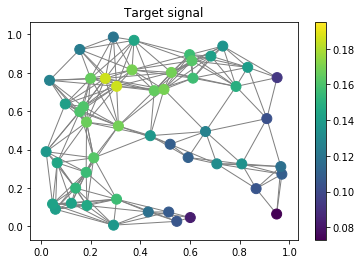

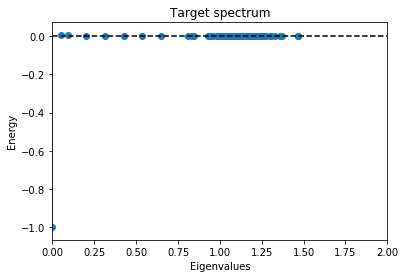

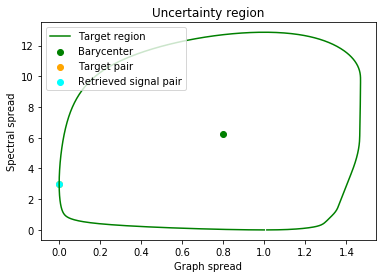

Last eigenvector
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.041220191915334
            Iterations: 1001
            Function evaluations: 55566
            Gradient evaluations: 1001


<Figure size 432x288 with 0 Axes>

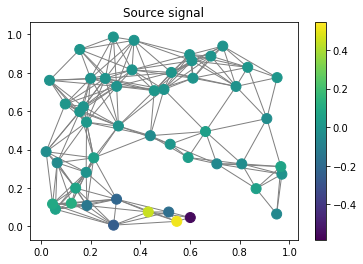

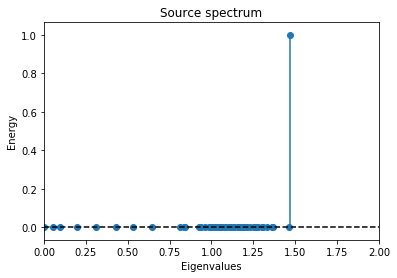

<Figure size 432x288 with 0 Axes>

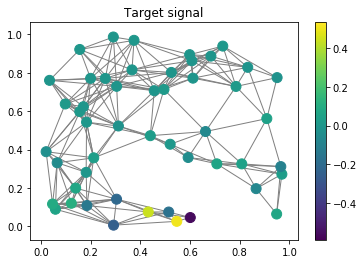

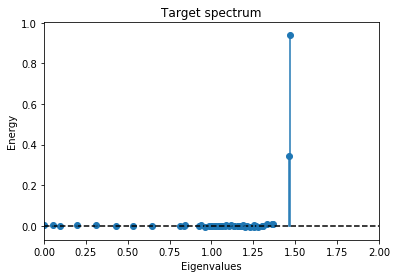

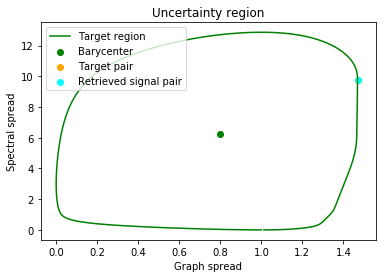

Middle eigenvector
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.06273410287812971
            Iterations: 455
            Function evaluations: 23938
            Gradient evaluations: 455


<Figure size 432x288 with 0 Axes>

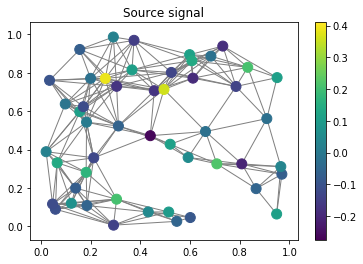

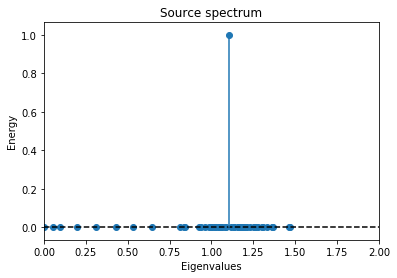

<Figure size 432x288 with 0 Axes>

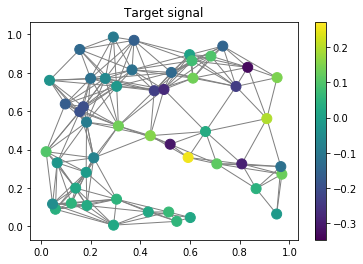

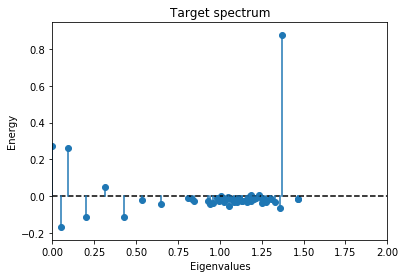

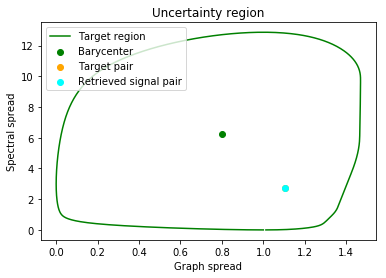

Gaussian kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.001960542236310757
            Iterations: 444
            Function evaluations: 25195
            Gradient evaluations: 444


<Figure size 432x288 with 0 Axes>

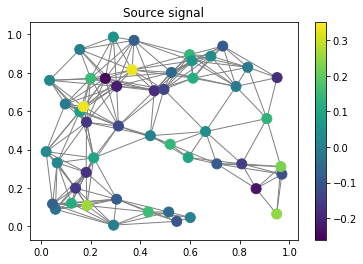

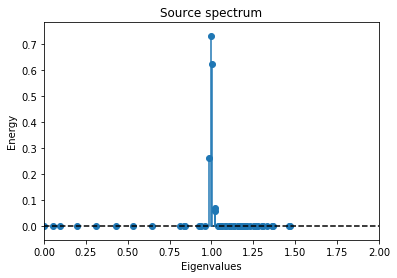

<Figure size 432x288 with 0 Axes>

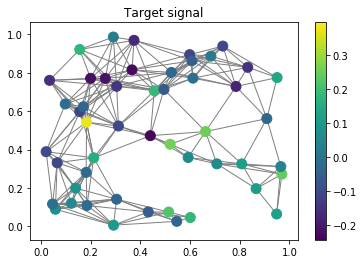

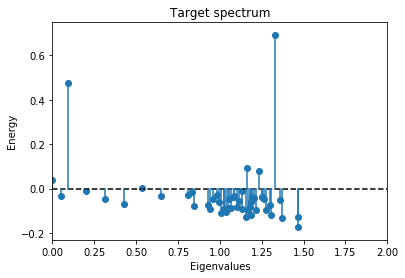

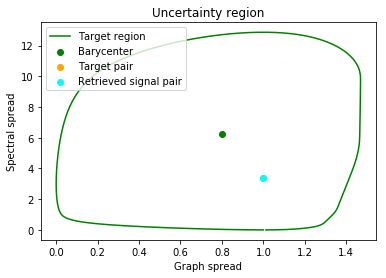

Chebyshev polynomial
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.9927963410217086e-05
            Iterations: 133
            Function evaluations: 7006
            Gradient evaluations: 133


<Figure size 432x288 with 0 Axes>

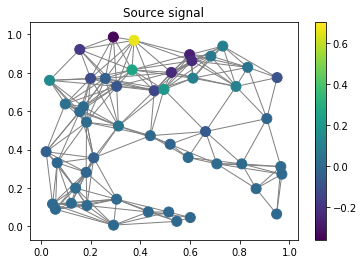

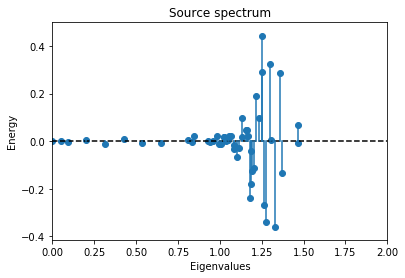

<Figure size 432x288 with 0 Axes>

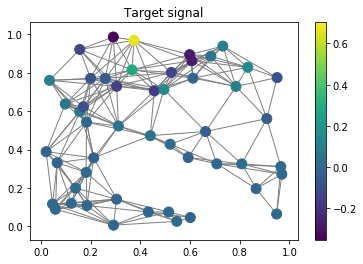

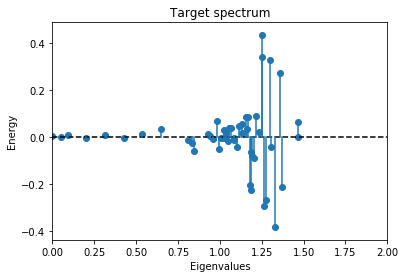

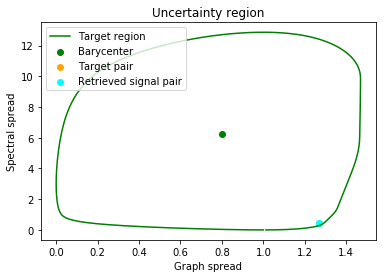

Random signal
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.960417170697411e-05
            Iterations: 71
            Function evaluations: 3762
            Gradient evaluations: 71


<Figure size 432x288 with 0 Axes>

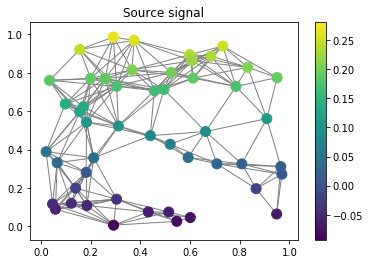

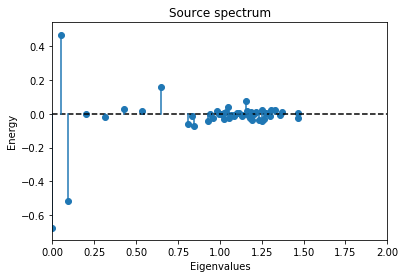

<Figure size 432x288 with 0 Axes>

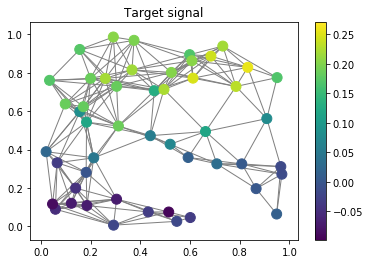

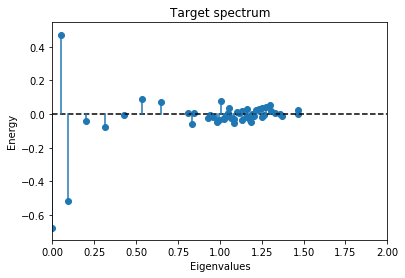

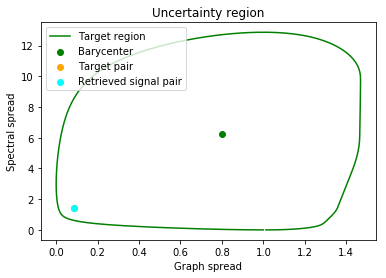

Dirac on ref vertex
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.792016819564577e-08
            Iterations: 58
            Function evaluations: 3068
            Gradient evaluations: 58


<Figure size 432x288 with 0 Axes>

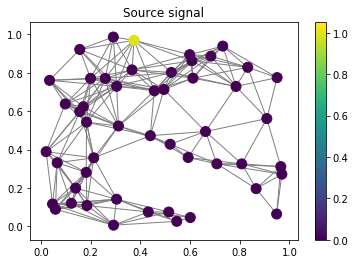

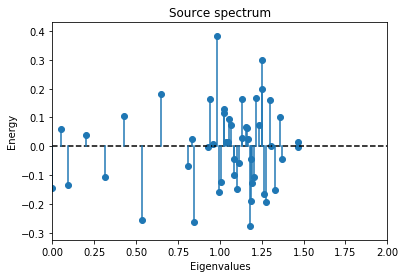

<Figure size 432x288 with 0 Axes>

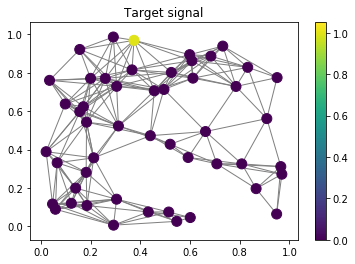

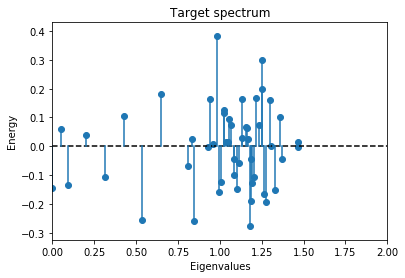

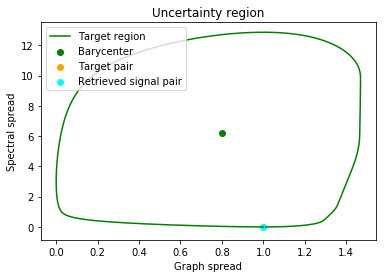

Dirac on some vertex
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.013817540591856272
            Iterations: 238
            Function evaluations: 13493
            Gradient evaluations: 238


<Figure size 432x288 with 0 Axes>

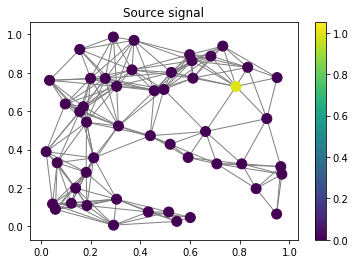

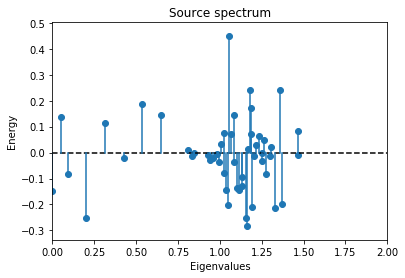

<Figure size 432x288 with 0 Axes>

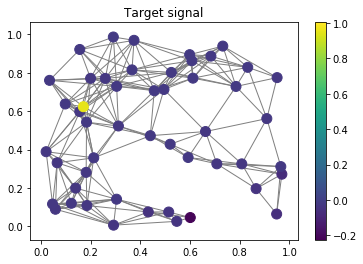

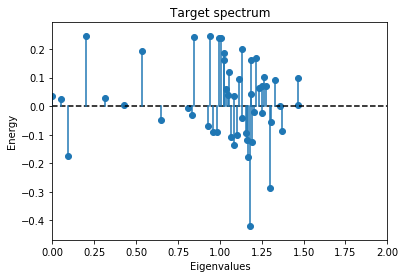

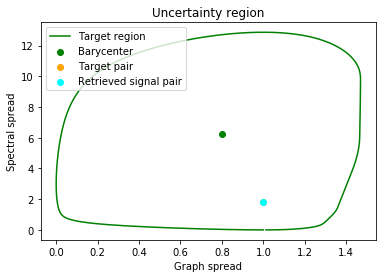

In [25]:
# Signals of interest
signals_of_interest = [(2.0 * source_graph.U.dot(numpy.random.rand(source_graph.N) - 0.5), "Random spectrum"), \
                       (source_graph.U[:, 0], "First eigenvector"), \
                       (source_graph.U[:, -1], "Last eigenvector"), \
                       (source_graph.U[:, int(source_graph.N / 2)], "Middle eigenvector"), \
                       (gaussian_kernel(source_graph, 1, 0.01), "Gaussian kernel"), \
                       (chebyshev_filter(source_graph.L, scipy.signal.unit_impulse(source_graph.N, REF_VERTEX_SOURCE), CHEBYSHEV_ORDER), "Chebyshev polynomial"), \
                       (2.0 * numpy.random.rand(source_graph.N) - 0.5, "Random signal"), \
                       (scipy.signal.unit_impulse(source_graph.N, REF_VERTEX_SOURCE), "Dirac on ref vertex"), \
                       (scipy.signal.unit_impulse(source_graph.N, int(source_graph.N / 2)), "Dirac on some vertex")]


# We try to retrieve them
for signal_of_interest in signals_of_interest :
    
    # Signal
    print("=" * 100)
    print(signal_of_interest[1])
    print("=" * 100)
    
    # Useful stuff
    source_signal = signal_of_interest[0] / numpy.linalg.norm(signal_of_interest[0])
    source_spectrum = source_graph.U.transpose().dot(source_signal)
    
    # Uncertainty regions of the two graphs
    source_region_border, _ = approximate_uncertainty_region(source_graph, ref_vertex=REF_VERTEX_SOURCE, ref_eigenvalue=REF_EIGENVALUE)
    target_region_border, _ = approximate_uncertainty_region(target_graph, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE)
    target_region_barycenter = compute_barycenter(target_region_border)
    
    # Uncertainty pair of the source signal in the source region, and its equivalent in the target region
    source_signal_pair = uncertainty_pair(source_graph, source_signal, ref_vertex=REF_VERTEX_SOURCE, ref_eigenvalue=REF_EIGENVALUE)
    target_signal_pair, _ = find_equivalent_pair(source_region_border, target_region_border, source_signal_pair)

    ##############################################################################################################
    
    # Heuristic to privilegiate solution with similar moments
    def function_to_optimize (current_signal) :

        # Parameters
        nb_moments = 10

        # Difference in moments between signals
        signal_moments_diffs = []
        for i in range(nb_moments) :
            signal_moments_diffs.append(numpy.abs(stats.moment(source_signal, moment=i) - stats.moment(current_signal, moment=i)))

        # Difference in moments between spectrums
        current_spectrum = target_graph.U.transpose().dot(current_signal)
        spectrum_moments_diffs = []
        for i in range(nb_moments) :
            spectrum_moments_diffs.append(numpy.abs(stats.moment(source_spectrum, moment=i) - stats.moment(current_spectrum, moment=i)))

        # Done
        return sum(signal_moments_diffs) + sum(spectrum_moments_diffs)

    ##############################################################################################################

    # We retrieve the signal on the target graph that achives that equivalent pair
    initial_signal = numpy.random.rand(target_graph.N)
    initial_signal /= numpy.linalg.norm(initial_signal)
    optimization_result = optimize.minimize(function_to_optimize, \
                                            initial_signal, \
                                            constraints=[{"type": "eq", "fun": lambda x: numpy.linalg.norm(target_signal_pair - uncertainty_pair(target_graph, x, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE))}, \
                                                         {"type": "eq", "fun": lambda x: numpy.linalg.norm(x) - 1}], \
                                            options={"disp": True, \
                                                     "maxiter": 1000}, \
                                            method="SLSQP")
    target_signal = optimization_result.x
    retrieved_signal_pair = uncertainty_pair(target_graph, target_signal, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE)
    
    # Plots
    plot_graph_signal(source_graph, source_signal, title="Source signal")
    plot_graph_signal_spectrum(source_graph, source_signal, title="Source spectrum")
    plot_graph_signal(target_graph, target_signal, title="Target signal")
    plot_graph_signal_spectrum(target_graph, target_signal, title="Target spectrum")
    plot_uncertainty_region([target_region_border, target_region_barycenter, target_signal_pair, retrieved_signal_pair], \
                            ["Target region", "Barycenter", "Target pair", "Retrieved signal pair"], \
                            colors=["green", "green", "orange", "cyan"], \
                            title="Uncertainty region")

# ========================== Script 3 ==========================

In [26]:
# Constants
N = 20
REF_VERTEX = 0
REF_EIGENVALUE = 0.0
NB_RANDOM_SIGNALS = 1000
NB_RANDOM_GRAPHS = 10
RANDOM_SEED = 42

<Figure size 432x288 with 0 Axes>

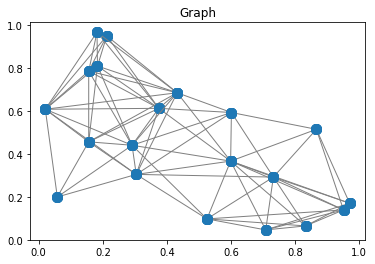

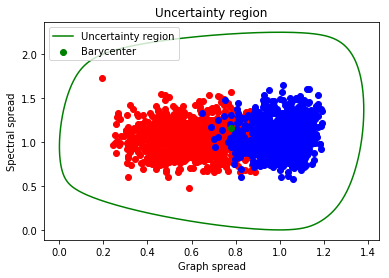

<Figure size 432x288 with 0 Axes>

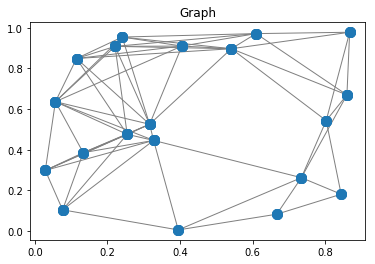

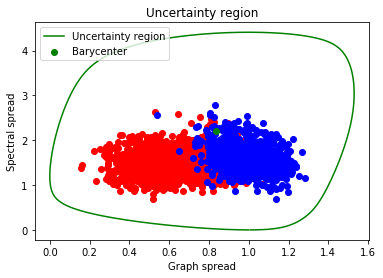

<Figure size 432x288 with 0 Axes>

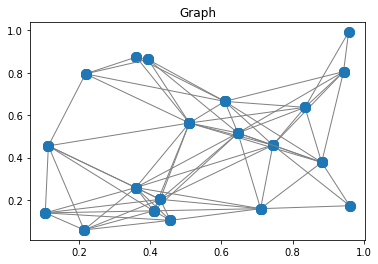

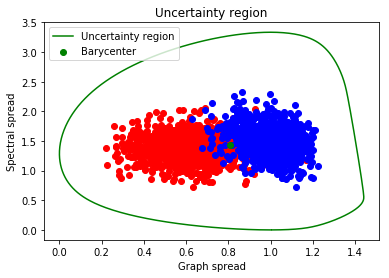

<Figure size 432x288 with 0 Axes>

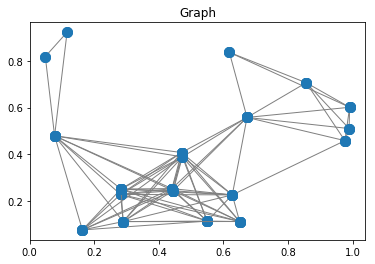

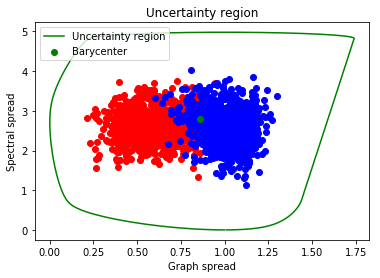

<Figure size 432x288 with 0 Axes>

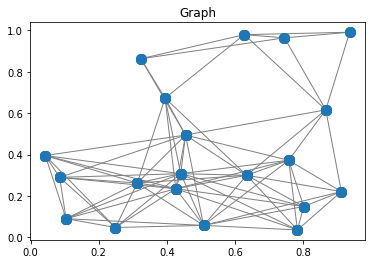

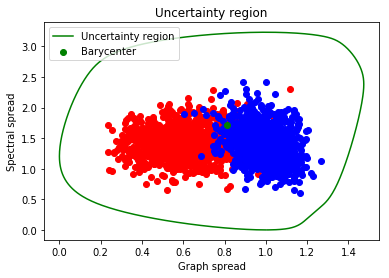

<Figure size 432x288 with 0 Axes>

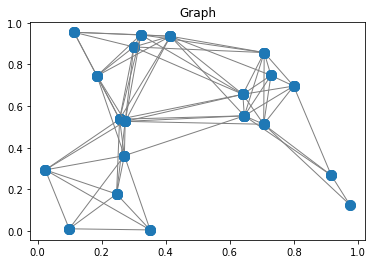

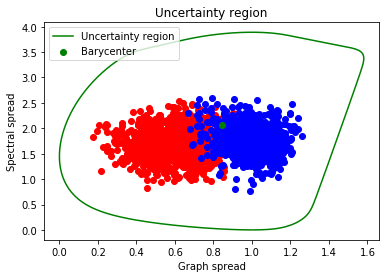

<Figure size 432x288 with 0 Axes>

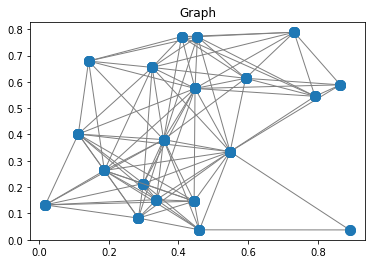

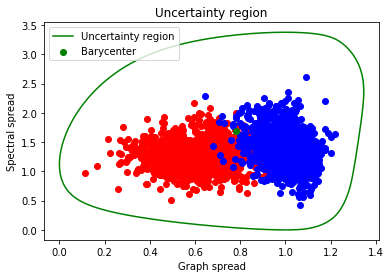

<Figure size 432x288 with 0 Axes>

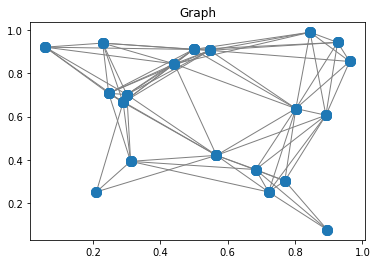

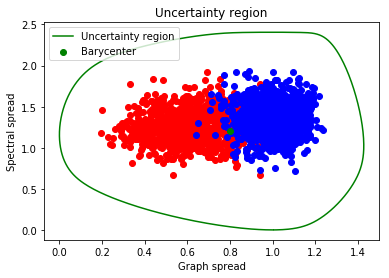

<Figure size 432x288 with 0 Axes>

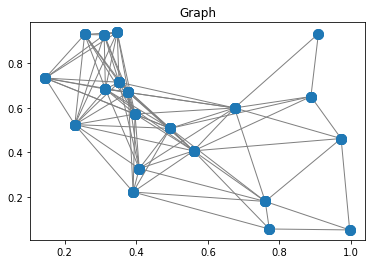

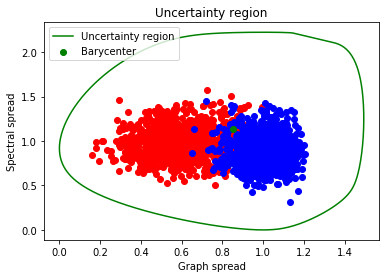

<Figure size 432x288 with 0 Axes>

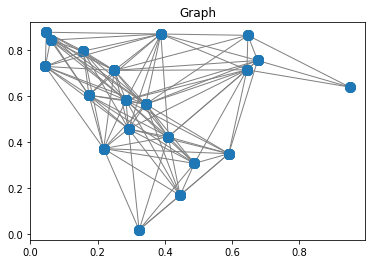

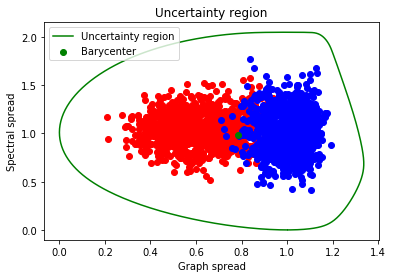

In [27]:
# Random seed
numpy.random.seed(RANDOM_SEED)

# Some random graphs
for i in range(NB_RANDOM_GRAPHS) :
    
    # Source graph
    source_graph = pygsp.graphs.Sensor(N, seed=(RANDOM_SEED+i))
    source_graph.compute_laplacian("normalized")
    source_graph.compute_fourier_basis()

    # Region
    source_region_border, _ = approximate_uncertainty_region(source_graph, ref_vertex=REF_VERTEX, ref_eigenvalue=REF_EIGENVALUE)
    source_region_barycenter = compute_barycenter(source_region_border)

    # Where do random signals go?
    all_signal_pairs = []
    all_spectrum_pairs = []
    for j in range(NB_RANDOM_SIGNALS) :

        # Random signal
        source_signal = 2.0 * numpy.random.rand(source_graph.N) - 0.5
        source_signal /= numpy.linalg.norm(source_signal)
        source_signal_pair = uncertainty_pair(source_graph, source_signal, ref_vertex=REF_VERTEX_SOURCE, ref_eigenvalue=REF_EIGENVALUE)
        all_signal_pairs.append(source_signal_pair)

        # Random signal
        source_spectrum = 2.0 * numpy.random.rand(source_graph.N) - 0.5
        source_spectrum /= numpy.linalg.norm(source_spectrum)
        source_spectrum_pair = uncertainty_pair(source_graph, source_graph.U.dot(source_spectrum), ref_vertex=REF_VERTEX_SOURCE, ref_eigenvalue=REF_EIGENVALUE)
        all_spectrum_pairs.append(source_spectrum_pair)

    # Plots
    plot_graph(source_graph, title="Graph")
    plot_uncertainty_region([*all_signal_pairs, *all_spectrum_pairs, source_region_border, source_region_barycenter], \
                            [""] * 2 * NB_RANDOM_SIGNALS + ["Uncertainty region", "Barycenter"], \
                            colors=["red"] * NB_RANDOM_SIGNALS + ["blue"] * NB_RANDOM_SIGNALS + ["green", "green"], \
                            title="Uncertainty region")
    

# ========================== Script 4 ==========================

In [127]:
# Constants
N_SOURCE = 100
N_TARGET = 150
REF_VERTEX_TARGET = 0
REF_EIGENVALUE = 0.0
CHEBYSHEV_ORDERS = [5, 20]
RANDOM_SEED = 42

<Figure size 432x288 with 0 Axes>

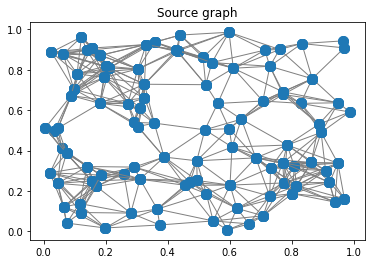

<Figure size 432x288 with 0 Axes>

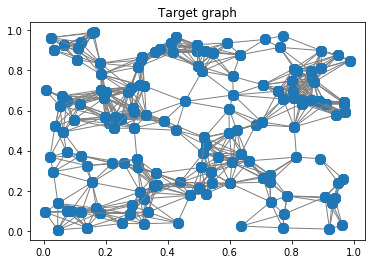

In [128]:
# Random seed
numpy.random.seed(RANDOM_SEED)

# Source graph
source_graph = pygsp.graphs.Sensor(N_SOURCE, seed=RANDOM_SEED)
source_graph.compute_laplacian("normalized")
source_graph.compute_fourier_basis()

# Target graph
target_graph = pygsp.graphs.Sensor(N_TARGET, seed=RANDOM_SEED)
target_graph.compute_laplacian("normalized")
target_graph.compute_fourier_basis()
target_region_border, _ = approximate_uncertainty_region(target_graph, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE)

######################################################################################################################

# Graphs
plot_graph(source_graph, title="Source graph")
plot_graph(target_graph, title="Target graph")

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.014085278709122559
            Iterations: 1001
            Function evaluations: 158327
            Gradient evaluations: 1001
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01175720993644128
            Iterations: 699
            Function evaluations: 107957
            Gradient evaluations: 699
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.013495050346757048
            Iterations: 1001
            Function evaluations: 159516
            Gradient evaluations: 1001
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.017762727924600336
            Iterations: 323
            Function evaluations: 49297
            Gradient evaluations: 323
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.016886975021769203
            Iterations: 617
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.023513040005343166
            Iterations: 487
            Function evaluations: 75074
            Gradient evaluations: 487
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01591348173674478
            Iterations: 387
            Function evaluations: 59105
            Gradient evaluations: 387
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010698454609392592
            Iterations: 298
            Function evaluations: 45497
            Gradient evaluations: 298
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0254148341133302
            Iterations: 1001
            Function evaluations: 159706
            Gradient evaluations: 1001
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.014993775419791251
            Iterations: 1001
            F

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.013855794620612037
            Iterations: 311
            Function evaluations: 47570
            Gradient evaluations: 311
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.016639928912643195
            Iterations: 130
            Function evaluations: 19831
            Gradient evaluations: 130
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.013647149725109598
            Iterations: 260
            Function evaluations: 39688
            Gradient evaluations: 260
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.011693573088781332
            Iterations: 237
            Function evaluations: 36149
            Gradient evaluations: 237
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015113435234173947
            Iter

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009072779716620273
            Iterations: 805
            Function evaluations: 123891
            Gradient evaluations: 805
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.01180145497521978
            Iterations: 1001
            Function evaluations: 158096
            Gradient evaluations: 1001
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02237882926165939
            Iterations: 575
            Function evaluations: 89179
            Gradient evaluations: 575
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01059005467315047
            Iterations: 976
            Function evaluations: 152406
            Gradient evaluations: 976
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.06792246635295285
            Iterations: 1001
            

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03609853421990247
            Iterations: 390
            Function evaluations: 59970
            Gradient evaluations: 390
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.039025809419576576
            Iterations: 643
            Function evaluations: 99798
            Gradient evaluations: 643
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.023486110337441926
            Iterations: 408
            Function evaluations: 63059
            Gradient evaluations: 408
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02560647760514073
            Iterations: 531
            Function evaluations: 81906
            Gradient evaluations: 531
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01206536192571132
            Iterati

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.013692891846983194
            Iterations: 1001
            Function evaluations: 156737
            Gradient evaluations: 1001
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.023836531717111895
            Iterations: 1001
            Function evaluations: 157579
            Gradient evaluations: 1001
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.020548067650677272
            Iterations: 1001
            Function evaluations: 154558
            Gradient evaluations: 1001
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.021604596461969078
            Iterations: 1001
            Function evaluations: 156901
            Gradient evaluations: 1001
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.02818514930814202
            Iterations: 1001
            Function evaluations: 158596


<Figure size 432x288 with 0 Axes>

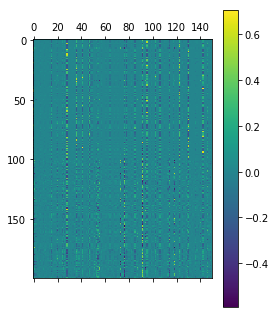

In [129]:
# Signals defined on source graph
X_source = []
for cheb_order in CHEBYSHEV_ORDERS :
    for i in range(source_graph.N) :

        # Signal on the source graph
        source_signal = chebyshev_filter(source_graph.L, scipy.signal.unit_impulse(source_graph.N, i), cheb_order)
        source_signal /= numpy.linalg.norm(source_signal)
        source_spectrum = source_graph.U.transpose().dot(source_signal)
        
        # Uncertainty pair of the source signal in the source region, and its equivalent in the target region
        source_signal_pair = uncertainty_pair(source_graph, source_signal, ref_vertex=i, ref_eigenvalue=REF_EIGENVALUE)
        source_region_border, _ = approximate_uncertainty_region(source_graph, ref_vertex=i, ref_eigenvalue=REF_EIGENVALUE)
        target_signal_pair, _ = find_equivalent_pair(source_region_border, target_region_border, source_signal_pair)

        ##############################################################################################################

        # Heuristic to privilegiate solution with similar moments
        def function_to_optimize (current_signal) :

            # Parameters
            nb_moments = 10

            # Difference in moments between signals
            signal_moments_diffs = []
            for i in range(nb_moments) :
                signal_moments_diffs.append(numpy.abs(stats.moment(source_signal, moment=i) - stats.moment(current_signal, moment=i)))

            # Difference in moments between spectrums
            current_spectrum = target_graph.U.transpose().dot(current_signal)
            spectrum_moments_diffs = []
            for i in range(nb_moments) :
                spectrum_moments_diffs.append(numpy.abs(stats.moment(source_spectrum, moment=i) - stats.moment(current_spectrum, moment=i)))

            # Done
            return sum(signal_moments_diffs) + sum(spectrum_moments_diffs)

        ##############################################################################################################

        # We retrieve the signal on the target graph that achives that equivalent pair
        initial_signal = numpy.random.rand(target_graph.N)
        initial_signal /= numpy.linalg.norm(initial_signal)
        optimization_result = optimize.minimize(function_to_optimize, \
                                                initial_signal, \
                                                constraints=[{"type": "eq", "fun": lambda x: numpy.linalg.norm(target_signal_pair - uncertainty_pair(target_graph, x, ref_vertex=REF_VERTEX_TARGET, ref_eigenvalue=REF_EIGENVALUE))}, \
                                                             {"type": "eq", "fun": lambda x: numpy.linalg.norm(x) - 1}], \
                                                options={"disp": True, \
                                                         "maxiter": 1000}, \
                                                method="SLSQP")
        target_signal = optimization_result.x
        X_source.append(target_signal)

# Plot
numpy.save("X_source.npy", X_source)
plot_matrix(X_source)


<Figure size 432x288 with 0 Axes>

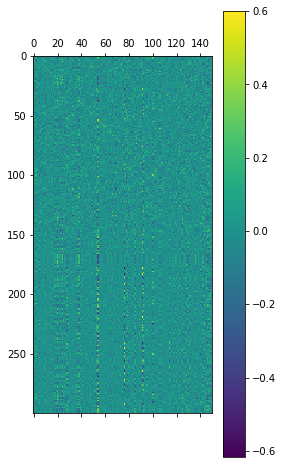

In [216]:
# Signals defined on target graph
X_target = []
spectrum_impulse_target_vertex = target_graph.U.transpose().dot(scipy.signal.unit_impulse(target_graph.N, REF_VERTEX_TARGET))
for cheb_order in CHEBYSHEV_ORDERS :
    for i in range(target_graph.N) :
        target_signal = chebyshev_filter(target_graph.L, scipy.signal.unit_impulse(target_graph.N, i), cheb_order)
        target_signal = target_graph.U.dot(spectrum_impulse_target_vertex * target_graph.U.transpose().dot(target_signal))
        target_signal /= numpy.linalg.norm(target_signal)
        X_target.append(target_signal)

# Plot
plot_matrix(X_target)

<Figure size 432x288 with 0 Axes>

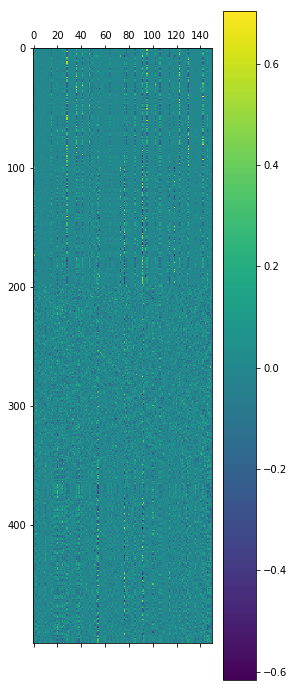

<Figure size 432x288 with 0 Axes>

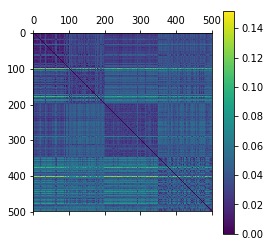

In [217]:
# We compute distance between signals
X_all = X_source + X_target
distances = numpy.zeros((len(X_all), len(X_all)))
for i in range(len(X_all)) :
    spectrum_i = target_graph.U.transpose().dot(X_all[i])
    spectrum_i = numpy.abs(spectrum_i) / numpy.sum(numpy.abs(spectrum_i))
    for j in range(i, len(X_all)) :
        spectrum_j = target_graph.U.transpose().dot(X_all[j])
        spectrum_j = numpy.abs(spectrum_j) / numpy.sum(numpy.abs(spectrum_j))
        distances[i, j] = numpy.linalg.norm(spectrum_i - spectrum_j)
        distances[j, i] = distances[i, j]

# Normalization
for i in range(len(distances)) :
    distances[:, i] /= numpy.linalg.norm(distances[:, i])

# Plot
plot_matrix(X_all)
plot_matrix(distances)

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 

<Figure size 432x288 with 0 Axes>

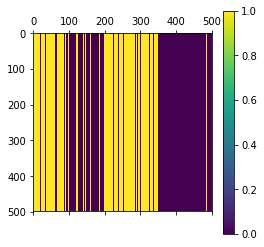

0
Signal 7
Signal 20
Signal 27
Signal 34
Signal 39
Signal 47
Signal 50
Signal 62
Signal 65
Signal 69
Signal 70
Signal 87
Signal 92
Signal 93
Signal 96
Signal 100
Signal 101
Signal 102
Signal 103
Signal 104
Signal 106
Signal 107
Signal 108
Signal 110
Signal 111
Signal 112
Signal 113
Signal 114
Signal 115
Signal 117
Signal 118
Signal 119
Signal 120
Signal 122
Signal 125
Signal 126
Signal 127
Signal 128
Signal 129
Signal 132
Signal 133
Signal 134
Signal 135
Signal 136
Signal 137
Signal 138
Signal 140
Signal 143
Signal 144
Signal 145
Signal 148
Signal 149
Signal 150
Signal 151
Signal 152
Signal 153
Signal 154
Signal 155
Signal 156
Signal 157
Signal 158
Signal 159
Signal 162
Signal 163
Signal 164
Signal 165
Signal 166
Signal 168
Signal 169
Signal 170
Signal 171
Signal 172
Signal 173
Signal 174
Signal 175
Signal 177
Signal 178
Signal 179
Signal 180
Signal 181
Signal 182
Signal 183
Signal 184
Signal 186
Signal 188
Signal 189
Signal 190
Signal 191
Signal 192
Signal 193
Signal 194
Signal 196
Si

In [221]:
# Clustering
clusterer = skcluster.AgglomerativeClustering(n_clusters=2)
clustering = clusterer.fit(distances)

# Result
print(clustering.labels_)
plot_matrix([clustering.labels_] * len(X_all))
for label in sorted(list(set(clustering.labels_))) :
    print("=" * 50)
    print(label)
    print("=" * 50)
    for i in range(len(X_all)) :
        if clustering.labels_[i] == label :
            print("Signal " + str(i))

# Recall & precision
print("=" * 50)
recall_1 = skmetrics.recall_score([1] * source_graph.N + [0] * source_graph.N + [1] * target_graph.N + [0] * target_graph.N, clustering.labels_)
precision_1 = skmetrics.precision_score([1] * source_graph.N + [0] * source_graph.N + [1] * target_graph.N + [0] * target_graph.N, clustering.labels_)
recall_2 = skmetrics.recall_score([0] * source_graph.N + [1] * source_graph.N + [0] * target_graph.N + [1] * target_graph.N, 1 - clustering.labels_)
precision_2 = skmetrics.precision_score([0] * source_graph.N + [1] * source_graph.N + [0] * target_graph.N + [1] * target_graph.N, 1 - clustering.labels_)
print("Recall K=" + str(CHEBYSHEV_ORDERS[0]) + ": " + str(recall_1))
print("Precision K=" + str(CHEBYSHEV_ORDERS[0]) + ": " + str(precision_1))
print("Recall K=" + str(CHEBYSHEV_ORDERS[1]) + ": " + str(recall_2))
print("Precision K=" + str(CHEBYSHEV_ORDERS[1]) + ": " + str(precision_2))